In [1]:
import truth_request as tr
import truth_analysis as ta
from imp import reload
from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse as date_parse
import auth
import requests
import json
import datetime as dt
import numpy as np
import statistics
from matplotlib import pyplot as plt

In [2]:
import orekit
from orekit.pyhelpers import  setup_orekit_curdir

In [3]:
orekit_vm = orekit.initVM()
setup_orekit_curdir("/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic/")

In [4]:
from ilrs import TruthEphemerisManager

In [5]:
import ilrs

In [118]:
#sgf_file = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220509_12901.sgf'
#hts_file = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220509_12901.hts'
#dgf_file = '/Users/gkeramidas/Projects/learning/truth/L5011/stella_cpf_220510_13001.dgf'
dgf_file = '/Users/gkeramidas/Projects/learning/truth/L2669/cryosat2_cpf_220509_12901.esa'

In [119]:
#sgf_eph = TruthEphemerisManager([sgf_file])
#hts_eph = TruthEphemerisManager([hts_file])
trial_eph = ilrs.TruthEphemerisManager([dgf_file])

In [6]:
epoch_dt = datetime(2022,5,9)

In [7]:
epoch_unix = (epoch_dt-datetime(1970, 1, 1, 0, 0, 0)).total_seconds()

In [8]:
timestep = 150
two_days_in_ts = 2*24*60*60/timestep

In [123]:
trial_X = []
trial_Y = []
trial_Z = []

curr_time = epoch_unix

for i in range(int(two_days_in_ts)):
    pos = trial_eph.position_at_unix_time(curr_time)
    trial_X.append(pos[0])
    trial_Y.append(pos[1])
    trial_Z.append(pos[2])
    
    curr_time += timestep

[]

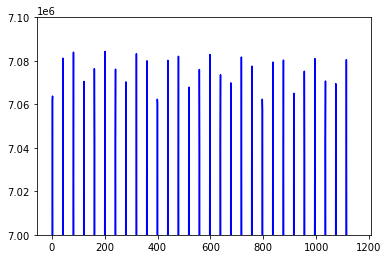

In [133]:
plt.plot(ts_list,trial_X,'r')
plt.plot(ts_list,trial_Y,'b')
#plt.plot(ts_list,trial_Z,'g')
plt.ylim(7e6,7.1e6)
plt.plot()

## Uncertainty in ECI coordinate system

In [84]:
diff_X = []
diff_Y = []
diff_Z = []

curr_time = epoch_unix

for i in range(int(two_days_in_ts)):
    err = sgf_eph.position_at_unix_time(curr_time) - hts_eph.position_at_unix_time(curr_time)
    diff_X.append(err[0])
    diff_Y.append(err[1])
    diff_Z.append(err[2])
    
    curr_time += timestep

In [39]:
ts_list = [x for x in range(int(two_days_in_ts))]

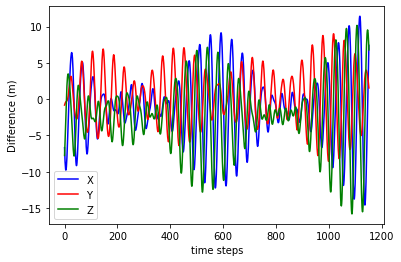

In [40]:
plt.plot(ts_list,diff_X,'b',label='X')
plt.plot(ts_list,diff_Y,'r',label='Y')
plt.plot(ts_list,diff_Z,'g',label='Z')
plt.legend()
plt.ylabel('Difference (m)')
plt.xlabel('time steps')
plt.show()

In [44]:
print("Uncertainty in X:", statistics.pstdev(diff_X))
print("Uncertainty in Y:", statistics.pstdev(diff_Y))
print("Uncertainty in Z:", statistics.pstdev(diff_Z))

Uncertainty in X: 4.703859109725261
Uncertainty in Y: 3.691590697442195
Uncertainty in Z: 4.669271509850129


## Velocity

In [45]:
diff_VX = []
diff_VY = []
diff_VZ = []

curr_time = epoch_unix

for i in range(int(two_days_in_ts)):
    Verr = sgf_eph.derived_velocity_at_unix_time(curr_time) - hts_eph.derived_velocity_at_unix_time(curr_time)
    diff_VX.append(Verr[0])
    diff_VY.append(Verr[1])
    diff_VZ.append(Verr[2])
    
    curr_time += timestep

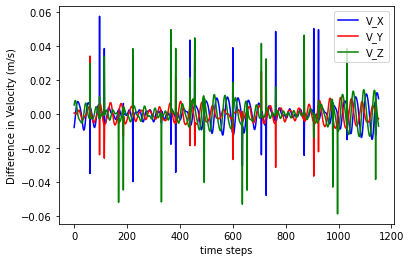

In [47]:
plt.plot(ts_list,diff_VX,'b',label='V_X')
plt.plot(ts_list,diff_VY,'r',label='V_Y')
plt.plot(ts_list,diff_VZ,'g',label='V_Z')
plt.legend()
plt.ylabel('Difference in Velocity (m/s)')
plt.xlabel('time steps')
plt.show()

## Move to RCI frame

In [16]:
from od_utils.frame_conversion import eci_to_rtn_rotation_matrix

In [49]:
sgf_eph.position_at_unix_time(epoch_unix)

array([-4838298.52684184,  3662560.868678  ,  3835665.73271627])

In [50]:
sgf_eph.derived_velocity_at_unix_time(epoch_unix)

array([ 3958.34597079, -1261.31653119,  6186.24961116])

In [53]:
RTN = eci_to_rtn_rotation_matrix(sgf_eph.position_at_unix_time(epoch_unix),sgf_eph.derived_velocity_at_unix_time(epoch_unix))

In [54]:
np.matmul(RTN,sgf_eph.position_at_unix_time(epoch_unix))

array([7178845.0578589,       0.       ,       0.       ])

## Position

In [57]:
diff_sgf_R = []
diff_sgf_I = []
diff_sgf_C = []

diff_hts_R = []
diff_hts_I = []
diff_hts_C = []

err2_R = []
err2_I = []
err2_C = []

curr_time = epoch_unix

for i in range(int(two_days_in_ts)):
    
    err = sgf_eph.position_at_unix_time(curr_time) - hts_eph.position_at_unix_time(curr_time)
    
    RTN_sgf = eci_to_rtn_rotation_matrix(sgf_eph.position_at_unix_time(curr_time),sgf_eph.derived_velocity_at_unix_time(curr_time))
    RTN_hts = eci_to_rtn_rotation_matrix(hts_eph.position_at_unix_time(curr_time),hts_eph.derived_velocity_at_unix_time(curr_time))
    
    sgf_RIC_err = np.matmul(RTN_sgf,err)
    hts_RIC_err = np.matmul(RTN_hts,err)
    
    err2_RIC = sgf_RIC_err - hts_RIC_err
    
    diff_sgf_R.append(sgf_RIC_err[0])
    diff_sgf_I.append(sgf_RIC_err[1])
    diff_sgf_C.append(sgf_RIC_err[2])
    
    diff_hts_R.append(hts_RIC_err[0])
    diff_hts_I.append(hts_RIC_err[1])
    diff_hts_C.append(hts_RIC_err[2])
    
    err2_R.append(err2_RIC[0])
    err2_I.append(err2_RIC[1])
    err2_C.append(err2_RIC[2])
    
    curr_time += timestep

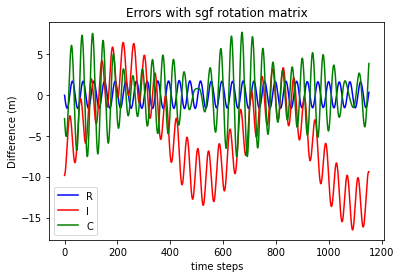

In [59]:
plt.plot(ts_list,diff_sgf_R,'b',label='R')
plt.plot(ts_list,diff_sgf_I,'r',label='I')
plt.plot(ts_list,diff_sgf_C,'g',label='C')
plt.legend()
plt.title("Errors with sgf rotation matrix")
plt.ylabel('Difference (m)')
plt.xlabel('time steps')
plt.show()

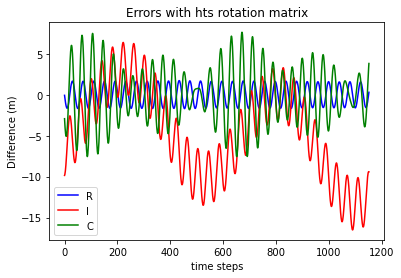

In [61]:
plt.plot(ts_list,diff_hts_R,'b',label='R')
plt.plot(ts_list,diff_hts_I,'r',label='I')
plt.plot(ts_list,diff_hts_C,'g',label='C')
plt.legend()
plt.title("Errors with hts rotation matrix")
plt.ylabel('Difference (m)')
plt.xlabel('time steps')
plt.show()

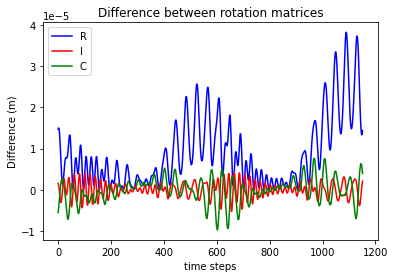

In [63]:
plt.plot(ts_list,err2_R,'b',label='R')
plt.plot(ts_list,err2_I,'r',label='I')
plt.plot(ts_list,err2_C,'g',label='C')
plt.legend()
plt.title("Difference between rotation matrices")
plt.ylabel('Difference (m)')
plt.xlabel('time steps')
plt.show()

Choice of rotation matrix is insignificant

In [97]:
print("Uncertainty in R:", 3*statistics.pstdev(diff_sgf_R))
print("Uncertainty in In-track:", 3*statistics.pstdev(diff_sgf_I))
print("Uncertainty in Cross-track:", 3*statistics.pstdev(diff_sgf_C))

Uncertainty in R: 3.4844499579642996
Uncertainty in In-track: 16.36472632238783
Uncertainty in Cross-track: 10.35928895092691


## Velocity

In [65]:
diff_sgf_VR = []
diff_sgf_VI = []
diff_sgf_VC = []

diff_hts_VR = []
diff_hts_VI = []
diff_hts_VC = []

err2_VR = []
err2_VI = []
err2_VC = []

curr_time = epoch_unix

for i in range(int(two_days_in_ts)):
    
    Verr = sgf_eph.derived_velocity_at_unix_time(curr_time) - hts_eph.derived_velocity_at_unix_time(curr_time)
    
    RTN_sgf = eci_to_rtn_rotation_matrix(sgf_eph.position_at_unix_time(curr_time),sgf_eph.derived_velocity_at_unix_time(curr_time))
    RTN_hts = eci_to_rtn_rotation_matrix(hts_eph.position_at_unix_time(curr_time),hts_eph.derived_velocity_at_unix_time(curr_time))
    
    sgf_RIC_Verr = np.matmul(RTN_sgf,Verr)
    hts_RIC_Verr = np.matmul(RTN_hts,Verr)
    
    Verr2_RIC = sgf_RIC_Verr - hts_RIC_Verr
    
    diff_sgf_VR.append(sgf_RIC_Verr[0])
    diff_sgf_VI.append(sgf_RIC_Verr[1])
    diff_sgf_VC.append(sgf_RIC_Verr[2])
    
    diff_hts_VR.append(hts_RIC_Verr[0])
    diff_hts_VI.append(hts_RIC_Verr[1])
    diff_hts_VC.append(hts_RIC_Verr[2])
    
    err2_VR.append(Verr2_RIC[0])
    err2_VI.append(Verr2_RIC[1])
    err2_VC.append(Verr2_RIC[2])
    
    curr_time += timestep

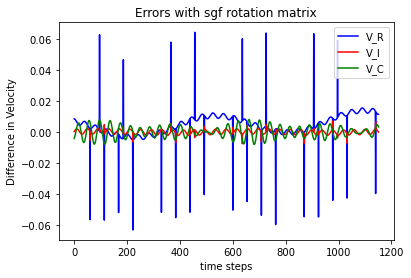

In [67]:
plt.plot(ts_list,diff_sgf_VR,'b',label='V_R')
plt.plot(ts_list,diff_sgf_VI,'r',label='V_I')
plt.plot(ts_list,diff_sgf_VC,'g',label='V_C')
plt.legend()
plt.title("Errors with sgf rotation matrix")
plt.ylabel('Difference in Velocity')
plt.xlabel('time steps')
plt.show()

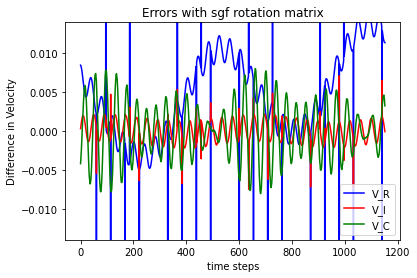

In [72]:
plt.plot(ts_list,diff_hts_VR,'b',label='V_R')
plt.plot(ts_list,diff_hts_VI,'r',label='V_I')
plt.plot(ts_list,diff_hts_VC,'g',label='V_C')
plt.legend()
plt.ylim(-0.014,0.014)
plt.title("Errors with sgf rotation matrix")
plt.ylabel('Difference in Velocity')
plt.xlabel('time steps')
plt.show()

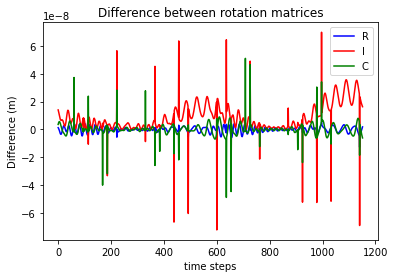

In [70]:
plt.plot(ts_list,err2_VR,'b',label='R')
plt.plot(ts_list,err2_VI,'r',label='I')
plt.plot(ts_list,err2_VC,'g',label='C')
plt.legend()
plt.title("Difference between rotation matrices")
plt.ylabel('Difference (m)')
plt.xlabel('time steps')
plt.show()

In [85]:
print("Uncertainty in R:", statistics.pstdev(diff_sgf_VR))
print("Uncertainty in In-track:", statistics.pstdev(diff_sgf_VI))
print("Uncertainty in Cross-track:", statistics.pstdev(diff_sgf_VC))

Uncertainty in R: 0.009755436736529849
Uncertainty in In-track: 0.001426113416254378
Uncertainty in Cross-track: 0.0036484042905512264


## Extract Error from single provider satellites

We will attempt to extract an error from a satellite where we only have a single provider (aka file-type) to work with. The strategy will be to get files from neighboring days and try to find differences in their propagations.

## SARAL

In [677]:
ninth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220509_12901.cne'
tenth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220510_13001.cne'
eleventh = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220511_13101.cne'
twelveth = '/Users/gkeramidas/Projects/learning/truth/L1471/saral_cpf_220512_13201.cne'

In [678]:
nin_eph = TruthEphemerisManager([ninth])
ten_eph = TruthEphemerisManager([tenth])
ele_eph = TruthEphemerisManager([eleventh])
twe_eph = TruthEphemerisManager([twelveth])

In [666]:
one_day = 24*60*60/timestep

In [667]:
ep_on_12th = epoch_unix + 3*one_day*timestep

In [676]:
ep_on_12th

1652313600.0

In [679]:
dX_one_day_away = []
dX_two_days_away = []
dX_three_days_away = []

dY_one_day_away = []
dY_two_days_away = []
dY_three_days_away = []

dZ_one_day_away = []
dZ_two_days_away = []
dZ_three_days_away = []

dR_one_day_away = []
dR_two_days_away = []
dR_three_days_away = []

dI_one_day_away = []
dI_two_days_away = []
dI_three_days_away = []

dC_one_day_away = []
dC_two_days_away = []
dC_three_days_away = []



curr_time = 0
for i in range(int(one_day)):
    one_day_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ele_eph.position_at_unix_time(ep_on_12th+curr_time)
    two_days_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ten_eph.position_at_unix_time(ep_on_12th+curr_time)
    three_days_away = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - nin_eph.position_at_unix_time(ep_on_12th+curr_time)
    
    
    RTN = eci_to_rtn_rotation_matrix(twe_eph.position_at_unix_time(ep_on_12th+curr_time),twe_eph.derived_velocity_at_unix_time(ep_on_12th+curr_time))
    
    
    one_day_RIC_err = np.matmul(RTN,one_day_away)
    two_days_RIC_err = np.matmul(RTN,two_days_away)
    three_days_RIC_err = np.matmul(RTN,three_days_away)
    
    
    dR_one_day_away.append(one_day_RIC_err[0])
    dI_one_day_away.append(one_day_RIC_err[1])
    dC_one_day_away.append(one_day_RIC_err[2])
    
    dR_two_days_away.append(two_days_RIC_err[0])
    dI_two_days_away.append(two_days_RIC_err[1])
    dC_two_days_away.append(two_days_RIC_err[2])
    
    dR_three_days_away.append(three_days_RIC_err[0])
    dI_three_days_away.append(three_days_RIC_err[1])
    dC_three_days_away.append(three_days_RIC_err[2])
    
    dX_one_day_away.append(one_day_away[0])
    dY_one_day_away.append(one_day_away[1])
    dZ_one_day_away.append(one_day_away[2])
    
    dX_two_days_away.append(two_days_away[0])
    dY_two_days_away.append(two_days_away[1])
    dZ_two_days_away.append(two_days_away[2])
    
    dX_three_days_away.append(three_days_away[0])
    dY_three_days_away.append(three_days_away[1])
    dZ_three_days_away.append(three_days_away[2])
    
    curr_time += timestep

In [669]:
ts_12_to_13 = [x for x in range(len(dX_one_day_away))]

## ECI frame


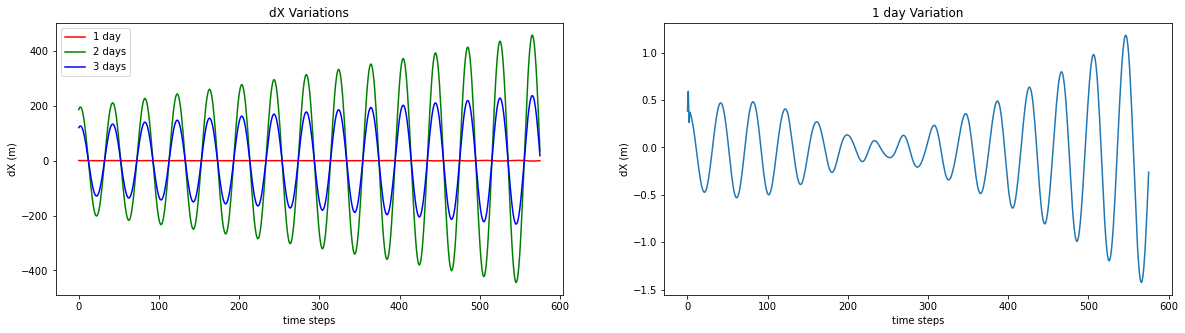

In [680]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dX_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dX_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dX_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dX_one_day_away)
ax1.set_xlabel('time steps')
ax1.set_ylabel('dX (m)')
ax2.set_xlabel('time steps')
ax2.set_ylabel('dX (m)')
ax1.set_title('dX Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

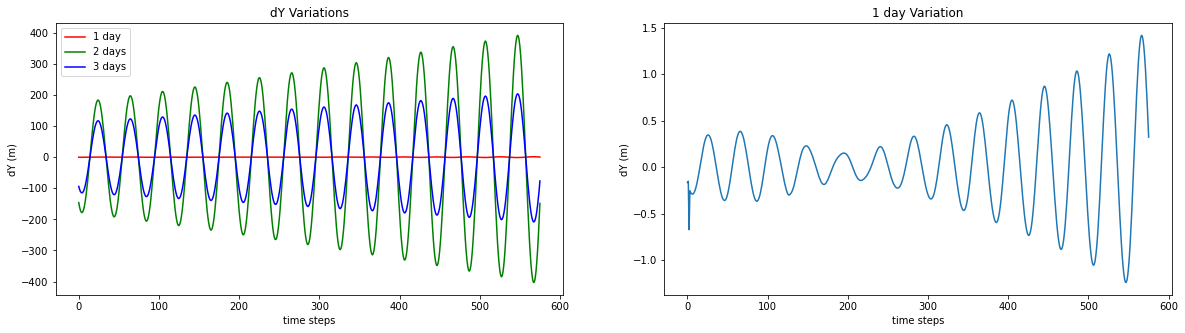

In [671]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dY_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dY_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dY_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dY_one_day_away)
ax1.set_xlabel('time steps')
ax2.set_xlabel('time steps')
ax1.set_ylabel('dY (m)')
ax2.set_ylabel('dY (m)')
ax1.set_title('dY Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

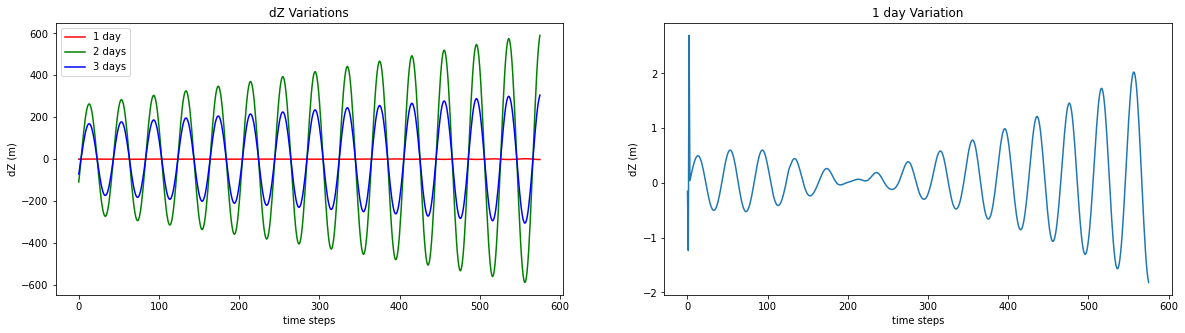

In [672]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dZ_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dZ_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dZ_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dZ_one_day_away)
ax1.set_xlabel('time steps')
ax2.set_xlabel('time steps')
ax1.set_ylabel('dZ (m)')
ax2.set_ylabel('dZ (m)')
ax1.set_title('dZ Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

## RIC frame

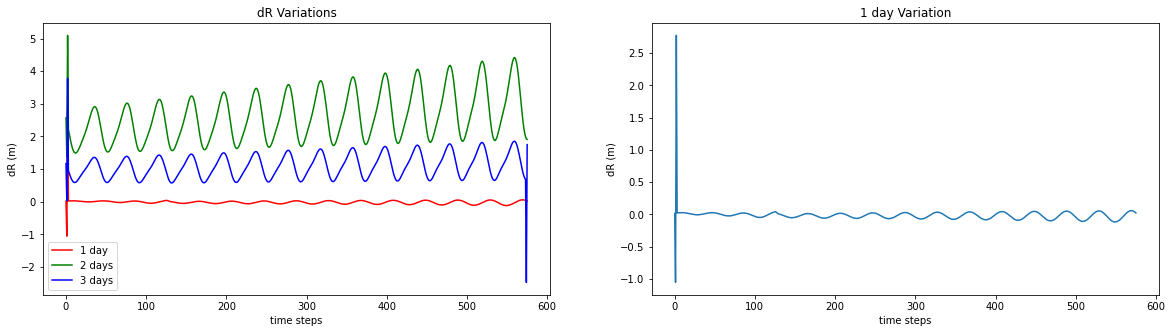

In [673]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dR_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dR_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dR_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dR_one_day_away)
ax1.set_xlabel('time steps')
ax1.set_ylabel('dR (m)')
ax2.set_xlabel('time steps')
ax2.set_ylabel('dR (m)')
ax1.set_title('dR Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

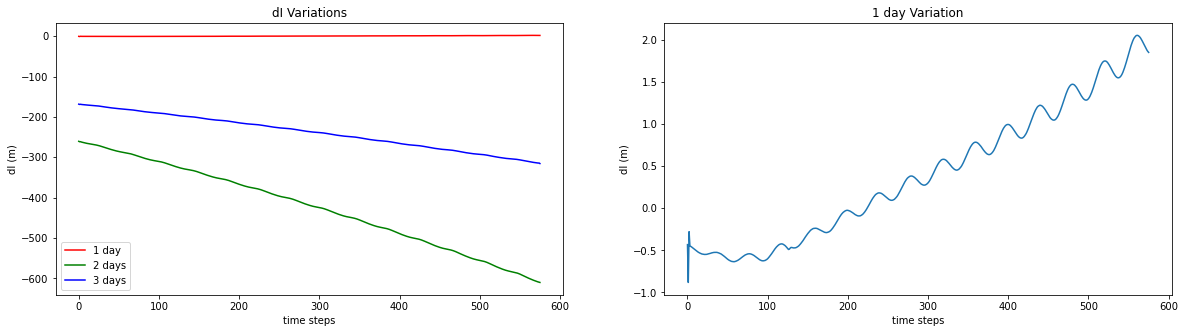

In [674]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dI_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dI_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dI_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dI_one_day_away)
ax1.set_xlabel('time steps')
ax1.set_ylabel('dI (m)')
ax2.set_xlabel('time steps')
ax2.set_ylabel('dI (m)')
ax1.set_title('dI Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

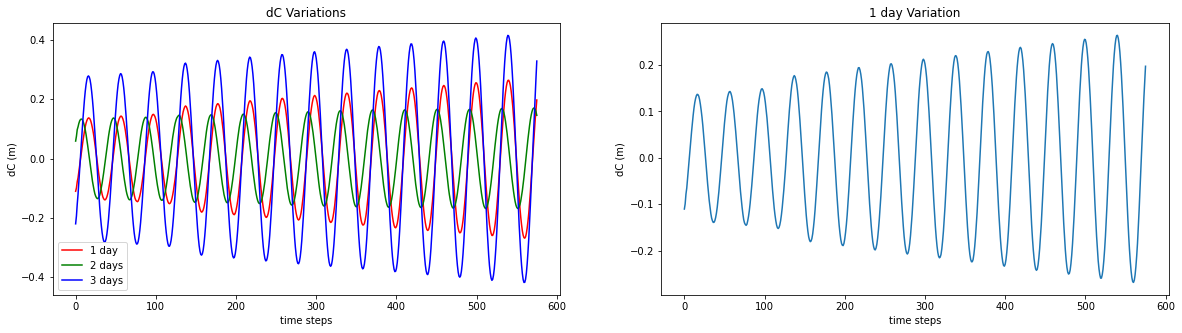

In [675]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.plot(ts_12_to_13,dC_one_day_away,'r',label = '1 day')
ax1.plot(ts_12_to_13,dC_two_days_away,'g',label = '2 days')
ax1.plot(ts_12_to_13,dC_three_days_away,'b',label = '3 days')
ax2.plot(ts_12_to_13,dC_one_day_away)
ax1.set_xlabel('time steps')
ax1.set_ylabel('dC (m)')
ax2.set_xlabel('time steps')
ax2.set_ylabel('dC (m)')
ax1.set_title('dC Variations')
ax2.set_title('1 day Variation')
ax1.legend()
plt.show()

A plausible explanation as to why the 1 day variation is so small is that perhaps, there were no new measurements incorporated between the two days.

An important idea is that the X,Y and Z coordinates will be periodic since they are coordinates of an orbit. Therefore, when we subtract two sinusoids we get a beat. Pressumably, if we find the offset of the two, then the subtraction should give us the error.

## Finding the Offset 

In [25]:
X_9 = []
X_10 = []
X_11 = []
X_12 = []

curr_time = 0
for i in range(int(one_day)):
    X_12.append(twe_eph.position_at_unix_time(ep_on_12th+curr_time)[0])
    X_11.append(ele_eph.position_at_unix_time(ep_on_12th+curr_time)[0])
    X_10.append(ten_eph.position_at_unix_time(ep_on_12th+curr_time)[0])
    X_9.append(nin_eph.position_at_unix_time(ep_on_12th+curr_time)[0])
    
    curr_time += timestep

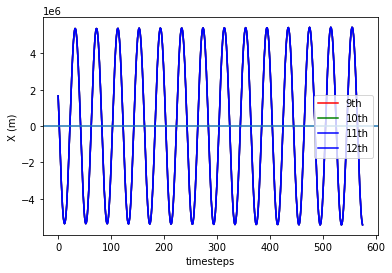

In [515]:
plt.plot(ts_12_to_13[:],X_9[:],'r',label="9th")
plt.plot(ts_12_to_13[:],X_10[:],'g',label="10th")
plt.plot(ts_12_to_13,X_11,'b',label="11th")
plt.plot(ts_12_to_13[:],X_12[:],'b',label="12th")
plt.axhline()
plt.xlabel("timesteps")
plt.ylabel("X (m)")
#plt.ylim(-0.21555555555e6,-0.215555555555e6)
#plt.xlim(42,43)
plt.legend()
plt.show()

## Try finding the offset in units of seconds

In [529]:
offset = np.linspace(-0.2,0.2,20)

In [520]:
curr_time = 0
#offset = [x for x in range(100)]
off_diff = []

for off in offset:
    curr_time = 0
    diffX = []
    for i in range(int(one_day)):
        
        diff = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ten_eph.position_at_unix_time(ep_on_12th+curr_time+off)
        diffX.append(diff[0])
        curr_time+=timestep
    off_diff.append(diffX)

In [516]:
curr_time = 0
offset = [10*x for x in range(10)]
off_diff = []

for off in offset:
    curr_time = 0
    diffX = []
    for i in range(int(one_day)):
        
        diff = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ten_eph.position_at_unix_time(ep_on_12th+curr_time+off)
        diffX.append(diff[0])
        curr_time+=timestep
    off_diff.append(diffX)

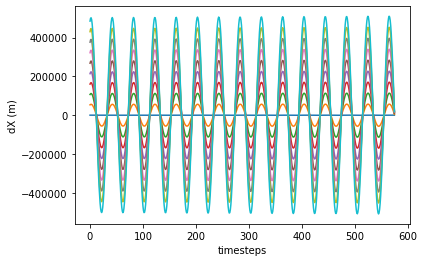

In [517]:
for i in [x for x in range(10)]:
    plt.plot(ts_12_to_13,off_diff[i][:])
    #plt.ylim(-50,50)
plt.xlabel("timesteps")
plt.ylabel("dX (m)")
#plt.title("X-position differences from -0.2s to 0.2s of offset")
plt.show()

In [521]:
for i in [x for x in range(20)]:
    print(statistics.pstdev(off_diff[i][:]))

572.8930129753668
489.5005462005851
406.289130782777
323.3976032357982
241.15887357244682
160.57665599172586
86.41632868700064
56.6246605590862
114.02002034546247
191.9646114686479
273.416154836185
355.9742167832787
439.0153769250168
522.3092568675401
605.7516079251874
689.2885062466676
772.8892898765796
856.5361953093552
940.2152667144184
1023.9193286399317


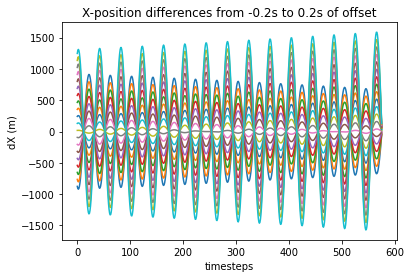

In [497]:
for i in [x for x in range(20)]:
    plt.plot(ts_12_to_13,off_diff[i][:])
    #plt.ylim(-50,50)
plt.xlabel("timesteps")
plt.ylabel("dX (m)")
plt.title("X-position differences from -0.2s to 0.2s of offset")
plt.show()

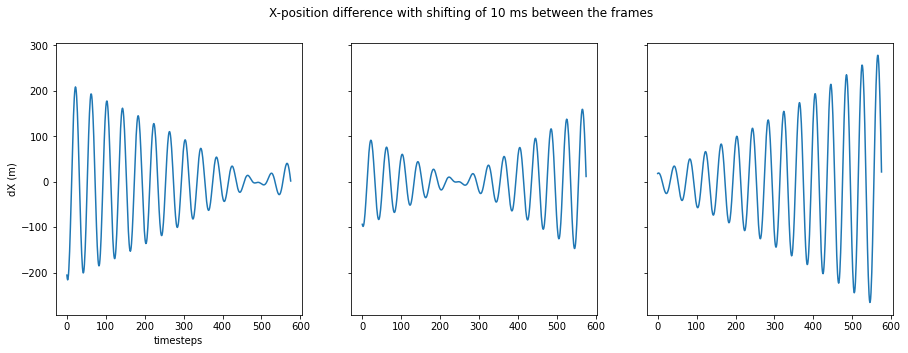

In [500]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharex=True,sharey=True,figsize = (15,5))
ax1.plot(ts_12_to_13,off_diff[6][:])
ax2.plot(ts_12_to_13,off_diff[7][:])
ax3.plot(ts_12_to_13,off_diff[8][:])
ax1.set_xlabel("timesteps")
ax1.set_ylabel("dX (m)")
plt.suptitle("X-position difference with shifting of 10 ms between the frames")
plt.show()

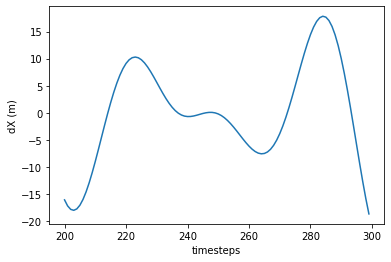

In [501]:
plt.plot(ts_12_to_13[200:300],off_diff[7][200:300])
plt.xlabel("timesteps")
plt.ylabel("dX (m)")
plt.show()

In [481]:
statistics.pstdev(off_diff[7][200:300])

9.198726566357506

When we try to subtract two waves the result can vary wildly based on the offset of them and their relative frequency.

When the values are so large as the values corresponding to orbit coordinates then even a slight detuning can lead to large values for the difference.

My hypothesis is that the propagations try to be syncronized but, perhaps due to numerical interpolation or numerical precision, they get very slightly detuned.

In the above plots I tried to locate the offset but it seems that there is no offset that we can slide one oscillation and make it exactly overlap the other. If there was such an offset we should be able to extract a difference curve that is not periodic or at least, it doesn't have the period of the original signals. 

It looks like we always have the precision problem and the two oscillations will eventually get detuned in the course of a day. It also looks like that with a shift in the order of tenths of a second, we can overlap the two curves for a brief period of time (before the detuning) and obtain a difference curve that is NOT periodic. 

In the above plots, we see the overlapping area moving through our difference curve like a pulse. The overlap lasts for about 100 timesteps but each of our timesteps is 150s. Therefore, the overlap lasts for about 4 hours. 

I believe that the most reasonable measure of uncertainty is the standard deviation of that, non-periodic, curve.

Could it be accidental or physical that a shifting of 60-70 ms can make the orbits line up so well for 4 hours?

## Try to use same offset for other dimensions

In [502]:
offset[7]

-0.052631578947368446

In [503]:
curr_time = 0
diffY = []
diffZ = []
for i in range(int(one_day)):
    diff = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - ten_eph.position_at_unix_time(ep_on_12th+curr_time+offset[7])
    diffY.append(diff[1])
    diffZ.append(diff[2])
    curr_time+=timestep

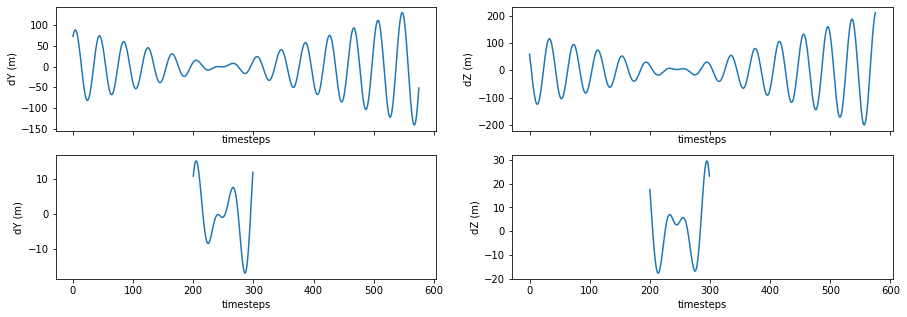

In [514]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,figsize=(15,5))
ax1.plot(ts_12_to_13,diffY)
ax2.plot(ts_12_to_13,diffZ)
ax3.plot(ts_12_to_13[200:300],diffY[200:300])
ax4.plot(ts_12_to_13[200:300],diffZ[200:300])
ax1.set_xlabel("timesteps")
ax2.set_xlabel("timesteps")
ax3.set_xlabel("timesteps")
ax4.set_xlabel("timesteps")
ax1.set_ylabel("dY (m)")
ax2.set_ylabel("dZ (m)")
ax3.set_ylabel("dY (m)")
ax4.set_ylabel("dZ (m)")
plt.show()

In [696]:
wave1 = [np.sin(2.01*x)+0.1 for x in np.linspace(0,100*2*np.pi,100)]
wave2 = [np.sin(2*x) for x in np.linspace(0,100*2*np.pi,100)]
wave_diff = np.array(wave2)-np.array(wave1)

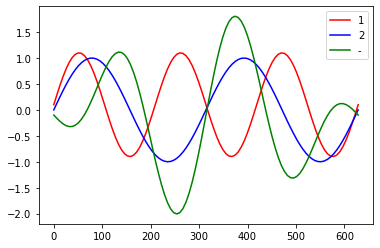

In [697]:
plt.plot(np.linspace(0,100*2*np.pi,100),wave1,'r',label="1")
plt.plot(np.linspace(0,100*2*np.pi,100),wave2,'b',label="2")
plt.plot(np.linspace(0,100*2*np.pi,100),wave_diff,'g',label="-")
plt.legend()
plt.show()

In [715]:
w1 = [np.sin(2.1*(x+0.3)) for x in np.linspace(0,20*np.pi,1000)]
w2 = [np.sin(2.*x) for x in np.linspace(0,20*np.pi,1000)]
wd = np.array(w2)-np.array(w1)

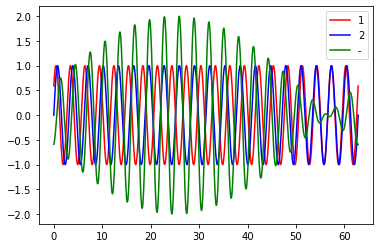

In [716]:
plt.plot(np.linspace(0,20*np.pi,1000),w1,'r',label="1")
plt.plot(np.linspace(0,20*np.pi,1000),w2,'b',label="2")
plt.plot(np.linspace(0,20*np.pi,1000),wd,'g',label="-")
plt.legend()
plt.show()

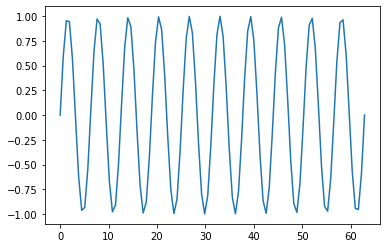

In [706]:
wv = [np.sin(x) for x in np.linspace(0,20*np.pi,100)]
plt.plot(np.linspace(0,20*np.pi,100),wv)
plt.show()

In [704]:
np.linspace(0,2*np.pi,100)


array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

## Difference with 9th ephemeris

In [550]:
curr_time = 0
#offset = [x for x in range(100)]
off_diff_9 = []
off_diff_R9 = []
off_diff_I9 = []
off_diff_C9 = []

for off in offset:
    curr_time = 0
    diffX_9 = []
    R_diff_9 = []
    I_diff_9 = []
    C_diff_9 = []
    for i in range(int(one_day)):
        diff = twe_eph.position_at_unix_time(ep_on_12th+curr_time) - nin_eph.position_at_unix_time(ep_on_12th+curr_time+off)
        
        RTN = eci_to_rtn_rotation_matrix(twe_eph.position_at_unix_time(ep_on_12th+curr_time),twe_eph.derived_velocity_at_unix_time(ep_on_12th+curr_time))
        
        RIC_diff = np.matmul(RTN,diff)
        
        R_diff_9.append(RIC_diff[0])
        I_diff_9.append(RIC_diff[1])
        C_diff_9.append(RIC_diff[2])
        
        diffX_9.append(diff[0])
        curr_time+=timestep
    off_diff_9.append(diffX_9)
    off_diff_R9.append(R_diff_9)
    off_diff_I9.append(I_diff_9)
    off_diff_C9.append(C_diff_9)

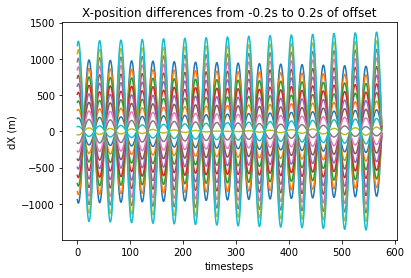

In [534]:
for i in [x for x in range(20)]:
    plt.plot(ts_12_to_13,off_diff_9[i][:])
    #plt.ylim(-50,50)
plt.xlabel("timesteps")
plt.ylabel("dX (m)")
plt.title("X-position differences from -0.2s to 0.2s of offset")
plt.show()

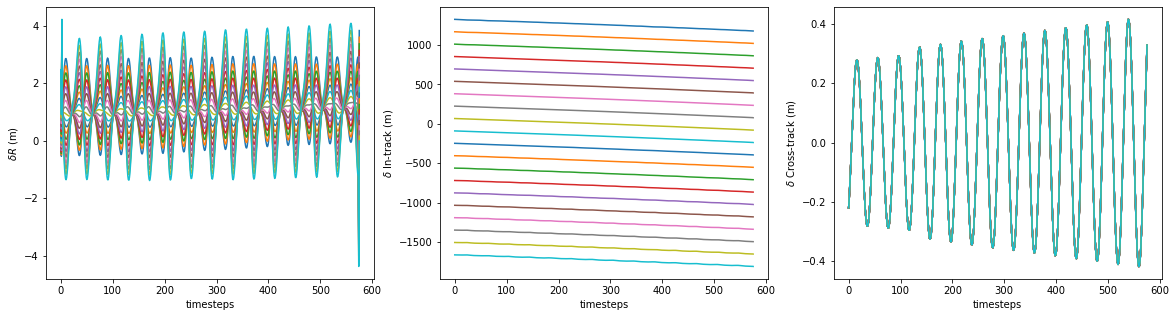

In [559]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
for i in [x for x in range(20)]:
    ax1.plot(ts_12_to_13,off_diff_R9[i][:])
    ax2.plot(ts_12_to_13,off_diff_I9[i][:])
    ax3.plot(ts_12_to_13,off_diff_C9[i][:])
ax1.set_ylabel(r"$\delta R$ (m)")
ax2.set_ylabel(r"$\delta$ In-track (m)")
ax3.set_ylabel(r"$\delta$ Cross-track (m)")
ax1.set_xlabel("timesteps")
ax2.set_xlabel("timesteps")
ax3.set_xlabel("timesteps")
plt.show()

In-track component is the most sensitive to timing errors

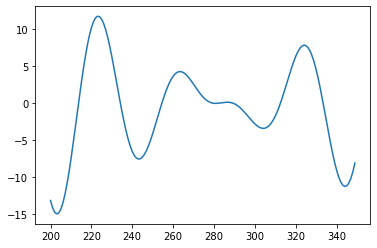

In [544]:
plt.plot(ts_12_to_13[200:350],off_diff_9[8][200:350])
plt.show()

In [545]:
statistics.pstdev(off_diff_9[8][200:350])

6.2835725112479945

In [546]:
statistics.pstdev(off_diff_9[8][:])

22.721791628659798

In [549]:
statistics.pstdev(off_diff_9[9][:])

88.15896946977516

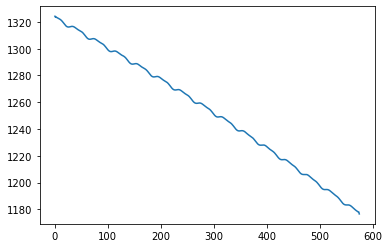

In [562]:
plt.plot(ts_12_to_13,off_diff_I9[0][:])
plt.show()

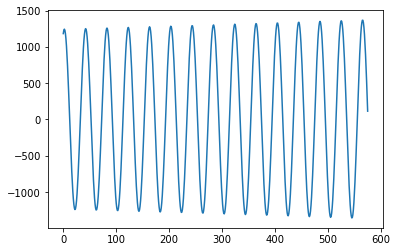

In [582]:
plt.plot(ts_12_to_13,off_diff_9[-1][:])
plt.show()

In [583]:
statistics.pstdev(off_diff_9[-1][:])

923.7916825756113

In [566]:
import random

In [604]:
Rand_Sample = random.sample(off_diff_9[-1][:],10)

In [605]:
statistics.pstdev(Rand_Sample)

709.664652887321

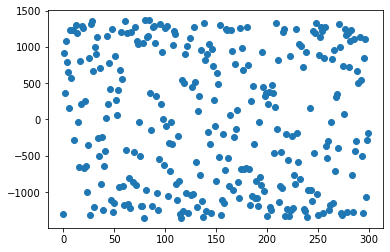

In [587]:
plt.scatter([x for x in range(300)],Rand_Sample)
plt.show()

std of derived std: 61.72365301108703
percentage error in std: 6.681555395584006


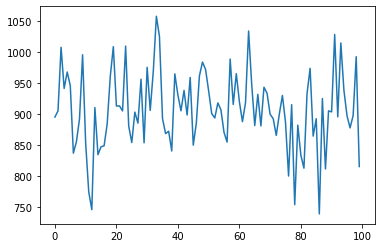

In [629]:
sample_size = 30
rnd_std = []
for i in range(100):
    Rand_Sample = random.sample(off_diff_9[-1][:],sample_size)
    rnd_std.append(statistics.pstdev(Rand_Sample))
print("std of derived std:", statistics.pstdev(rnd_std))
print("percentage error in std:", (statistics.pstdev(rnd_std)/statistics.pstdev(off_diff_9[-1][:]))*100)
plt.plot([x for x in range(100)],rnd_std)
plt.show()

## Download 30 days of data for SARAL

In [633]:
import os

In [630]:
tr.dwld_data_for_target('L1471',[2022,5,9],30)

info Syncing ILRS truth data from S3 (35 files downloaded)


In [646]:
class tephem:
    def __init__(self, day, month, ephem):
        self.day = day
        self.month = month
        self.ephem = ephem

In [647]:
ephemerides = []
directory = '/Users/gkeramidas/Projects/learning/truth/L1471/'
for file in os.listdir(directory):
    date = file.split("_")[-2]
    month = "".join(list(date)[2:4])
    day = "".join(list(date)[4:])
    #eph = TruthEphemerisManager([directory+file])
    #ephemerides.append(tephem(day,eph))
    print(date)
    print(month,day)

220417
04 17
220508
05 08
220411
04 11
220416
04 16
220509
05 09
220410
04 10
220501
05 01
220507
05 07
220418
04 18
220506
05 06
220419
04 19
220429
04 29
220408
04 08
220409
04 09
220428
04 28
220430
04 30
220407
04 07
220426
04 26
220420
04 20
220427
04 27
220406
04 06
220421
04 21
220414
04 14
220412
04 12
220415
04 15
220413
04 13
220502
05 02
220504
05 04
220503
05 03
220505
05 05
220425
04 25
220423
04 23
220405
04 05
220424
04 24
220422
04 22


In [644]:
ephemerides.sort(key=lambda x: x.day)

In [645]:
ephemerides[0].day

'01'

In [648]:
int('04')

4

In [662]:
def days_before(day1, month1, day2, month2):
    day1 = int(day1)
    day2 = int(day2)
    month1 = int(month1)
    month2 = int(month2)
    
    if month1 < month2:
        pass
    if month1 == month2:
        if day1 <= day2:
            pass
        else:
            tmp = day1
            day1 = day2
            day2 = tmp
    if month1 > month2:
        temp_month = month1
        month1 = month2
        month2 = temp_month
        temp_day = day1
        day1 = day2
        day2 = temp_day
    
    if month2 in [1,3,5,7,8,11,12]:
        modulo = 31
    if month2 == 2:
        modulo = 28
    if month2 in [4,6,9,10]:
        modulo = 30
    
    days_bef = (day2-day1)%modulo
    #print(month1,day1,month2,day2)
    print(days_bef)
        

In [663]:
days_before(15,5,10,5)

5
